## 1. Dados
Carregamos os dados a seguir


In [1]:
import pandas as pd

data = pd.read_csv("sol3ghz.dat",header =None)
data.head()


,0
0,269.0
1,264.0
2,252.0
3,246.0
4,242.0


In [15]:
data.describe()

,0
count,6000.000000
mean,263.171333
std,67.776330
min,182.000000
25%,207.000000
50%,250.000000
75%,293.000000
max,632.000000


<IPython.core.display.Javascript object>


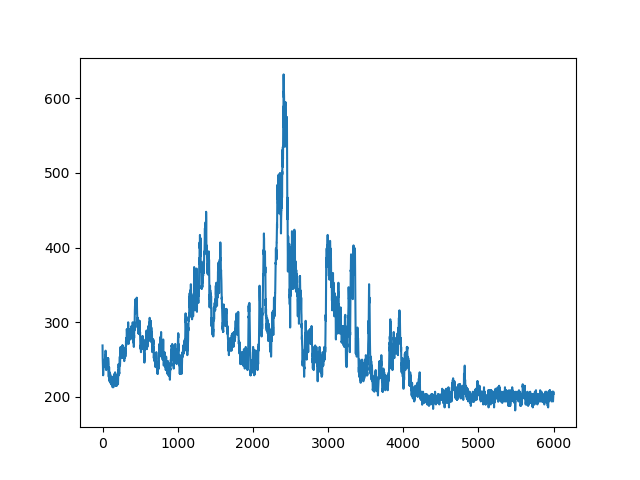

In [3]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.figure()
plt.plot(data)
plt.show()

Para trabalhar com uma rede neural é interessante normalizar os dados

<IPython.core.display.Javascript object>


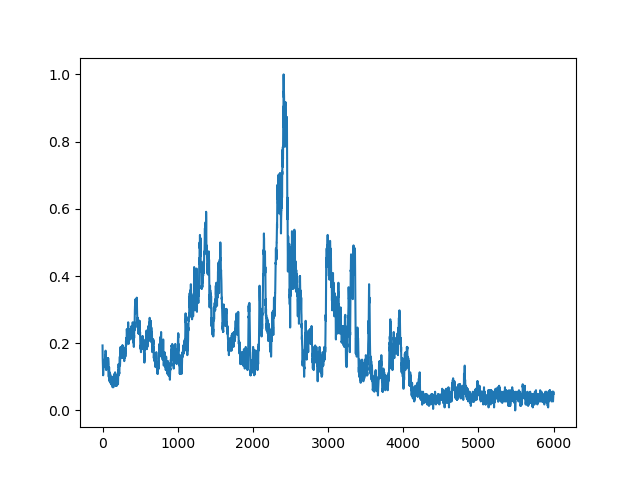

In [4]:
maximo,minimo  = data.max(), data.min() 
norm = (data-minimo)/(maximo-minimo)
plt.figure()
plt.plot(norm)
plt.show()

# 2. Redes Neurais
Carregando as bibliotecas de redes neurais

In [141]:
import numpy as np
#tensorflow:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, GRU,LSTM, Embedding, Dropout
from tensorflow.keras.optimizers import RMSprop, SGD

## 2.1 LSTM

In [142]:
model = Sequential()

#tamanho da subserie temporal
tamanhoSerie = 128

#Apenas uma camada para inicio:
model.add(LSTM(units=int(1.5*tamanhoSerie),input_shape=(tamanhoSerie,1)))
model.add(Dense(1, activation='sigmoid'))

In [143]:
model.compile(loss='mean_squared_error', optimizer=RMSprop())
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 192)               148992    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 193       
Total params: 149,185
Trainable params: 149,185
Non-trainable params: 0
_________________________________________________________________


In [144]:
def batchGen(serie,tamanhoSerie,tamnanhoLote):
     while True:
        x_shape = (tamnanhoLote, tamanhoSerie,1)
        x_batch = np.zeros(shape=x_shape)
        y_shape = (tamnanhoLote, 1)
        y_batch = np.zeros(shape=y_shape)
        
        random = np.random.randint(len(serie)-tamnanhoLote*tamanhoSerie-1)
        for b in range(tamnanhoLote):
            x_batch[b,:,0] = serie[random:random+tamanhoSerie][0].values
            y_batch[b,:] = serie.iloc[random+tamanhoSerie+1].values[0]
            random = random+tamanhoSerie
        yield(x_batch,y_batch)

In [145]:
gen = batchGen(norm,tamanhoSerie,10)
#next(gen)

In [146]:
model.fit_generator(gen, epochs=10,steps_per_epoch=20)

Epoch 1/10
20/20 [==============================] - 19s 974ms/step - loss: 0.0413
Epoch 2/10
20/20 [==============================] - 17s 840ms/step - loss: 0.0358
Epoch 3/10
20/20 [==============================] - 23s 1s/step - loss: 0.0334
Epoch 4/10
20/20 [==============================] - 23s 1s/step - loss: 0.0206
Epoch 5/10
20/20 [==============================] - 26s 1s/step - loss: 0.0206
Epoch 6/10
20/20 [==============================] - 19s 938ms/step - loss: 0.0177
Epoch 7/10
20/20 [==============================] - 19s 934ms/step - loss: 0.0086
Epoch 8/10
20/20 [==============================] - 18s 910ms/step - loss: 0.0105
Epoch 9/10
20/20 [==============================] - 22s 1s/step - loss: 0.0059
Epoch 10/10
20/20 [==============================] - 23s 1s/step - loss: 0.0049


## Previsão

Para realizar a previsão, dividimos a série temporal em pedaços do tamanho e formato de entrada da rede.

Inicialmente preparamos a rede com o suporte dos dados originais até completar 2/3 do tamanho da série original. Após isto, adicionamos gradativamente os passos previsto pela rede e realimentamos a rede com esta saída dos passos anteriores. Sendo assim, somente após 2/3 do tempo decorrido realizamos a previsão.

In [220]:
pedacos = norm[:len(norm)-len(norm)%tamanhoSerie][0].values
toPredict = []

In [221]:
for i in range(int(3*len(pedacos)/7)):
    toPredict.append(pedacos[i:i+tamanhoSerie])
toPredict = np.array(toPredict)
shape = toPredict.shape
toPredict = toPredict.reshape(shape[0],shape[1],1)
print(toPredict.shape)

(2523, 128, 1)


In [222]:
pred = model.predict(toPredict)
pred = pred.reshape(pred.shape[0]*pred.shape[1])
x_pred = [i for i in range(tamanhoSerie+1,len(pred)+tamanhoSerie+1)]

<IPython.core.display.Javascript object>


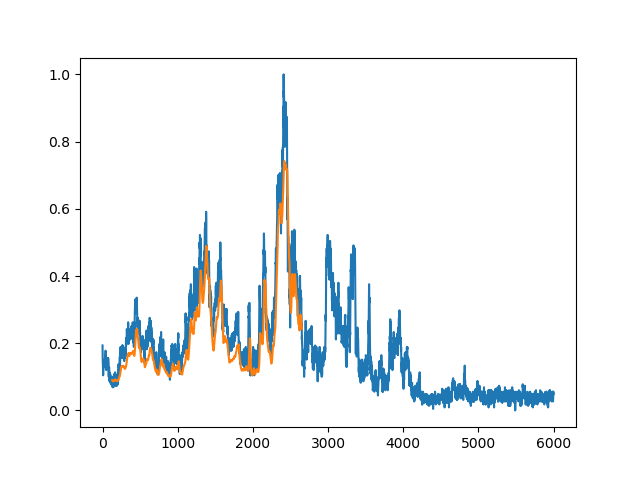

In [223]:
plt.figure()
plt.plot(norm)
plt.plot(x_pred, pred)
plt.show()

Adicionando cada passo de tempo a serie temporal de previsao e realizando a previsao desde o inicio

In [224]:
def stepPredict(model,toPredict,tamanhoSerie, serie, acc):
    serie2 = serie
    
    #prevendo o proximo passo de tempo 
    pred = model.predict(toPredict)
    pred = pred.reshape(pred.shape[0]*pred.shape[1])
    acc = np.append(acc,pred[len(pred)-1])
    serie2 = np.append(serie,pred[len(pred)-1]+np.random.rand()/10)
    
    #adicionando o proximo passo
    batch = np.zeros(shape=(tamanhoSerie,tamanhoSerie,1))
    
    for i in range(tamanhoSerie-1,0,-1):
        batch[i,:,0] = serie2[len(serie2)-1-i-tamanhoSerie:len(serie2)-1-i]
    
    return np.array(batch), serie2, acc

In [231]:
toPredict2 = toPredict
pred2 = pred

toPredict2, pred2, t_pred = stepPredict(model, toPredict2, tamanhoSerie,pred,[])
tx_pred = [x_pred[len(x_pred)-1]]
for i in range(2000):
    toPredict2, pred2, t_pred = stepPredict(model, toPredict2, tamanhoSerie,pred2,t_pred)
    tx_pred.append(tx_pred[len(tx_pred)-1]+1)
    print("Time step:", tx_pred[len(tx_pred)-1], i)
    #print(toPredict2)

Time step: 2652 0
Time step: 2653 1
Time step: 2654 2
Time step: 2655 3
Time step: 2656 4
Time step: 2657 5
Time step: 2658 6
Time step: 2659 7
Time step: 2660 8
Time step: 2661 9
Time step: 2662 10
Time step: 2663 11
Time step: 2664 12
Time step: 2665 13
Time step: 2666 14
Time step: 2667 15
Time step: 2668 16
Time step: 2669 17
Time step: 2670 18
Time step: 2671 19
Time step: 2672 20
Time step: 2673 21
Time step: 2674 22
Time step: 2675 23
Time step: 2676 24
Time step: 2677 25
Time step: 2678 26
Time step: 2679 27
Time step: 2680 28
Time step: 2681 29
Time step: 2682 30
Time step: 2683 31
Time step: 2684 32
Time step: 2685 33
Time step: 2686 34
Time step: 2687 35
Time step: 2688 36
Time step: 2689 37
Time step: 2690 38
Time step: 2691 39
Time step: 2692 40
Time step: 2693 41
Time step: 2694 42
Time step: 2695 43
Time step: 2696 44
Time step: 2697 45
Time step: 2698 46
Time step: 2699 47
Time step: 2700 48
Time step: 2701 49
Time step: 2702 50
Time step: 2703 51
Time step: 2704 52
Tim

Time step: 3068 416
Time step: 3069 417
Time step: 3070 418
Time step: 3071 419
Time step: 3072 420
Time step: 3073 421
Time step: 3074 422
Time step: 3075 423
Time step: 3076 424
Time step: 3077 425
Time step: 3078 426
Time step: 3079 427
Time step: 3080 428
Time step: 3081 429
Time step: 3082 430
Time step: 3083 431
Time step: 3084 432
Time step: 3085 433
Time step: 3086 434
Time step: 3087 435
Time step: 3088 436
Time step: 3089 437
Time step: 3090 438
Time step: 3091 439
Time step: 3092 440
Time step: 3093 441
Time step: 3094 442
Time step: 3095 443
Time step: 3096 444
Time step: 3097 445
Time step: 3098 446
Time step: 3099 447
Time step: 3100 448
Time step: 3101 449
Time step: 3102 450
Time step: 3103 451
Time step: 3104 452
Time step: 3105 453
Time step: 3106 454
Time step: 3107 455
Time step: 3108 456
Time step: 3109 457
Time step: 3110 458
Time step: 3111 459
Time step: 3112 460
Time step: 3113 461
Time step: 3114 462
Time step: 3115 463
Time step: 3116 464
Time step: 3117 465


Time step: 3478 826
Time step: 3479 827
Time step: 3480 828
Time step: 3481 829
Time step: 3482 830
Time step: 3483 831
Time step: 3484 832
Time step: 3485 833
Time step: 3486 834
Time step: 3487 835
Time step: 3488 836
Time step: 3489 837
Time step: 3490 838
Time step: 3491 839
Time step: 3492 840
Time step: 3493 841
Time step: 3494 842
Time step: 3495 843
Time step: 3496 844
Time step: 3497 845
Time step: 3498 846
Time step: 3499 847
Time step: 3500 848
Time step: 3501 849
Time step: 3502 850
Time step: 3503 851
Time step: 3504 852
Time step: 3505 853
Time step: 3506 854
Time step: 3507 855
Time step: 3508 856
Time step: 3509 857
Time step: 3510 858
Time step: 3511 859
Time step: 3512 860
Time step: 3513 861
Time step: 3514 862
Time step: 3515 863
Time step: 3516 864
Time step: 3517 865
Time step: 3518 866
Time step: 3519 867
Time step: 3520 868
Time step: 3521 869
Time step: 3522 870
Time step: 3523 871
Time step: 3524 872
Time step: 3525 873
Time step: 3526 874
Time step: 3527 875


Time step: 3877 1225
Time step: 3878 1226
Time step: 3879 1227
Time step: 3880 1228
Time step: 3881 1229
Time step: 3882 1230
Time step: 3883 1231
Time step: 3884 1232
Time step: 3885 1233
Time step: 3886 1234
Time step: 3887 1235
Time step: 3888 1236
Time step: 3889 1237
Time step: 3890 1238
Time step: 3891 1239
Time step: 3892 1240
Time step: 3893 1241
Time step: 3894 1242
Time step: 3895 1243
Time step: 3896 1244
Time step: 3897 1245
Time step: 3898 1246
Time step: 3899 1247
Time step: 3900 1248
Time step: 3901 1249
Time step: 3902 1250
Time step: 3903 1251
Time step: 3904 1252
Time step: 3905 1253
Time step: 3906 1254
Time step: 3907 1255
Time step: 3908 1256
Time step: 3909 1257
Time step: 3910 1258
Time step: 3911 1259
Time step: 3912 1260
Time step: 3913 1261
Time step: 3914 1262
Time step: 3915 1263
Time step: 3916 1264
Time step: 3917 1265
Time step: 3918 1266
Time step: 3919 1267
Time step: 3920 1268
Time step: 3921 1269
Time step: 3922 1270
Time step: 3923 1271
Time step: 39

Time step: 4268 1616
Time step: 4269 1617
Time step: 4270 1618
Time step: 4271 1619
Time step: 4272 1620
Time step: 4273 1621
Time step: 4274 1622
Time step: 4275 1623
Time step: 4276 1624
Time step: 4277 1625
Time step: 4278 1626
Time step: 4279 1627
Time step: 4280 1628
Time step: 4281 1629
Time step: 4282 1630
Time step: 4283 1631
Time step: 4284 1632
Time step: 4285 1633
Time step: 4286 1634
Time step: 4287 1635
Time step: 4288 1636
Time step: 4289 1637
Time step: 4290 1638
Time step: 4291 1639
Time step: 4292 1640
Time step: 4293 1641
Time step: 4294 1642
Time step: 4295 1643
Time step: 4296 1644
Time step: 4297 1645
Time step: 4298 1646
Time step: 4299 1647
Time step: 4300 1648
Time step: 4301 1649
Time step: 4302 1650
Time step: 4303 1651
Time step: 4304 1652
Time step: 4305 1653
Time step: 4306 1654
Time step: 4307 1655
Time step: 4308 1656
Time step: 4309 1657
Time step: 4310 1658
Time step: 4311 1659
Time step: 4312 1660
Time step: 4313 1661
Time step: 4314 1662
Time step: 43

<IPython.core.display.Javascript object>


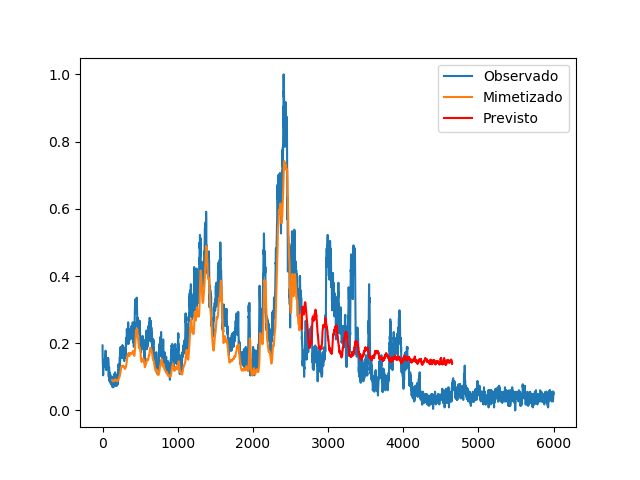

In [234]:
plt.figure()
plt.plot(norm,label="Observado")
plt.plot(x_pred,pred,label="Mimetizado")
plt.plot(tx_pred,t_pred,color="red",label="Previsto")
plt.legend()
plt.show()

## 2.2 GRU

O procedimento para o uso de camadas com neurônios GRU é similar ao procedimento utilizado com LSTM

In [253]:
model = Sequential()

#tamanho da subserie temporal
tamanhoSerie = 128

#Apenas uma camada para inicio:
model.add(GRU(units=int(1.5*tamanhoSerie),input_shape=(tamanhoSerie,1)))

model.add(Dense(1, activation='sigmoid'))

In [243]:
model.compile(loss='mean_squared_error', optimizer=RMSprop())
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 192)               111744    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 193       
Total params: 111,937
Trainable params: 111,937
Non-trainable params: 0
_________________________________________________________________


In [244]:
def batchGen(serie,tamanhoSerie,tamnanhoLote):
     while True:
        x_shape = (tamnanhoLote, tamanhoSerie,1)
        x_batch = np.zeros(shape=x_shape)
        y_shape = (tamnanhoLote, 1)
        y_batch = np.zeros(shape=y_shape)
        
        random = np.random.randint(len(serie)-tamnanhoLote*tamanhoSerie-1)
        for b in range(tamnanhoLote):
            x_batch[b,:,0] = serie[random:random+tamanhoSerie][0].values
            y_batch[b,:] = serie.iloc[random+tamanhoSerie+1].values[0]
            random = random+tamanhoSerie
        yield(x_batch,y_batch)

In [245]:
gen = batchGen(norm,tamanhoSerie,10)
#next(gen)

In [247]:
model.fit_generator(gen, epochs=10,steps_per_epoch=20)

Epoch 1/10
20/20 [==============================] - 17s 838ms/step - loss: 0.0838
Epoch 2/10
20/20 [==============================] - 16s 796ms/step - loss: 0.0740
Epoch 3/10
20/20 [==============================] - 17s 860ms/step - loss: 0.0449
Epoch 4/10
20/20 [==============================] - 17s 874ms/step - loss: 0.0251
Epoch 5/10
20/20 [==============================] - 17s 842ms/step - loss: 0.0151
Epoch 6/10
20/20 [==============================] - 19s 934ms/step - loss: 0.0164
Epoch 7/10
20/20 [==============================] - 18s 909ms/step - loss: 0.0058
Epoch 8/10
20/20 [==============================] - 15s 742ms/step - loss: 0.0059
Epoch 9/10
20/20 [==============================] - 14s 725ms/step - loss: 0.0035
Epoch 10/10
20/20 [==============================] - 19s 952ms/step - loss: 0.0042


<IPython.core.display.Javascript object>


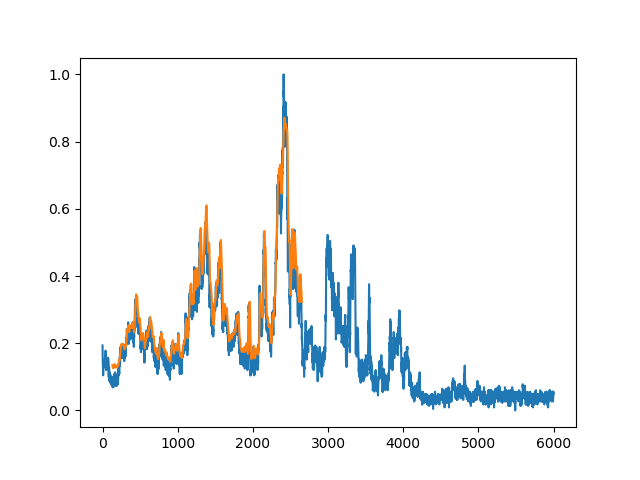

In [248]:
pedacos = norm[:len(norm)-len(norm)%tamanhoSerie][0].values
toPredict = []
for i in range(int(3*len(pedacos)/7)):
    toPredict.append(pedacos[i:i+tamanhoSerie])
toPredict = np.array(toPredict)
shape = toPredict.shape
toPredict = toPredict.reshape(shape[0],shape[1],1)
pred = model.predict(toPredict)
pred = pred.reshape(pred.shape[0]*pred.shape[1])
x_pred = [i for i in range(tamanhoSerie+1,len(pred)+tamanhoSerie+1)]

plt.figure()
plt.plot(norm)
plt.plot(x_pred, pred)
plt.show()

In [249]:
def stepPredict(model,toPredict,tamanhoSerie, serie, acc):
    serie2 = serie
    
    #prevendo o proximo passo de tempo 
    pred = model.predict(toPredict)
    pred = pred.reshape(pred.shape[0]*pred.shape[1])
    acc = np.append(acc,pred[len(pred)-1])
    serie2 = np.append(serie,pred[len(pred)-1]+np.random.rand()/10)
    
    #adicionando o proximo passo
    batch = np.zeros(shape=(tamanhoSerie,tamanhoSerie,1))
    
    for i in range(tamanhoSerie-1,0,-1):
        batch[i,:,0] = serie2[len(serie2)-1-i-tamanhoSerie:len(serie2)-1-i]
    
    return np.array(batch), serie2, acc

In [250]:
toPredict2 = toPredict
pred2 = pred

toPredict2, pred2, t_pred = stepPredict(model, toPredict2, tamanhoSerie,pred,[])
tx_pred = [x_pred[len(x_pred)-1]]
for i in range(2000):
    toPredict2, pred2, t_pred = stepPredict(model, toPredict2, tamanhoSerie,pred2,t_pred)
    tx_pred.append(tx_pred[len(tx_pred)-1]+1)
    print("Time step:", tx_pred[len(tx_pred)-1], i)
    #print(toPredict2)

Time step: 2652 0
Time step: 2653 1
Time step: 2654 2
Time step: 2655 3
Time step: 2656 4
Time step: 2657 5
Time step: 2658 6
Time step: 2659 7
Time step: 2660 8
Time step: 2661 9
Time step: 2662 10
Time step: 2663 11
Time step: 2664 12
Time step: 2665 13
Time step: 2666 14
Time step: 2667 15
Time step: 2668 16
Time step: 2669 17
Time step: 2670 18
Time step: 2671 19
Time step: 2672 20
Time step: 2673 21
Time step: 2674 22
Time step: 2675 23
Time step: 2676 24
Time step: 2677 25
Time step: 2678 26
Time step: 2679 27
Time step: 2680 28
Time step: 2681 29
Time step: 2682 30
Time step: 2683 31
Time step: 2684 32
Time step: 2685 33
Time step: 2686 34
Time step: 2687 35
Time step: 2688 36
Time step: 2689 37
Time step: 2690 38
Time step: 2691 39
Time step: 2692 40
Time step: 2693 41
Time step: 2694 42
Time step: 2695 43
Time step: 2696 44
Time step: 2697 45
Time step: 2698 46
Time step: 2699 47
Time step: 2700 48
Time step: 2701 49
Time step: 2702 50
Time step: 2703 51
Time step: 2704 52
Tim

Time step: 3068 416
Time step: 3069 417
Time step: 3070 418
Time step: 3071 419
Time step: 3072 420
Time step: 3073 421
Time step: 3074 422
Time step: 3075 423
Time step: 3076 424
Time step: 3077 425
Time step: 3078 426
Time step: 3079 427
Time step: 3080 428
Time step: 3081 429
Time step: 3082 430
Time step: 3083 431
Time step: 3084 432
Time step: 3085 433
Time step: 3086 434
Time step: 3087 435
Time step: 3088 436
Time step: 3089 437
Time step: 3090 438
Time step: 3091 439
Time step: 3092 440
Time step: 3093 441
Time step: 3094 442
Time step: 3095 443
Time step: 3096 444
Time step: 3097 445
Time step: 3098 446
Time step: 3099 447
Time step: 3100 448
Time step: 3101 449
Time step: 3102 450
Time step: 3103 451
Time step: 3104 452
Time step: 3105 453
Time step: 3106 454
Time step: 3107 455
Time step: 3108 456
Time step: 3109 457
Time step: 3110 458
Time step: 3111 459
Time step: 3112 460
Time step: 3113 461
Time step: 3114 462
Time step: 3115 463
Time step: 3116 464
Time step: 3117 465


Time step: 3478 826
Time step: 3479 827
Time step: 3480 828
Time step: 3481 829
Time step: 3482 830
Time step: 3483 831
Time step: 3484 832
Time step: 3485 833
Time step: 3486 834
Time step: 3487 835
Time step: 3488 836
Time step: 3489 837
Time step: 3490 838
Time step: 3491 839
Time step: 3492 840
Time step: 3493 841
Time step: 3494 842
Time step: 3495 843
Time step: 3496 844
Time step: 3497 845
Time step: 3498 846
Time step: 3499 847
Time step: 3500 848
Time step: 3501 849
Time step: 3502 850
Time step: 3503 851
Time step: 3504 852
Time step: 3505 853
Time step: 3506 854
Time step: 3507 855
Time step: 3508 856
Time step: 3509 857
Time step: 3510 858
Time step: 3511 859
Time step: 3512 860
Time step: 3513 861
Time step: 3514 862
Time step: 3515 863
Time step: 3516 864
Time step: 3517 865
Time step: 3518 866
Time step: 3519 867
Time step: 3520 868
Time step: 3521 869
Time step: 3522 870
Time step: 3523 871
Time step: 3524 872
Time step: 3525 873
Time step: 3526 874
Time step: 3527 875


Time step: 3877 1225
Time step: 3878 1226
Time step: 3879 1227
Time step: 3880 1228
Time step: 3881 1229
Time step: 3882 1230
Time step: 3883 1231
Time step: 3884 1232
Time step: 3885 1233
Time step: 3886 1234
Time step: 3887 1235
Time step: 3888 1236
Time step: 3889 1237
Time step: 3890 1238
Time step: 3891 1239
Time step: 3892 1240
Time step: 3893 1241
Time step: 3894 1242
Time step: 3895 1243
Time step: 3896 1244
Time step: 3897 1245
Time step: 3898 1246
Time step: 3899 1247
Time step: 3900 1248
Time step: 3901 1249
Time step: 3902 1250
Time step: 3903 1251
Time step: 3904 1252
Time step: 3905 1253
Time step: 3906 1254
Time step: 3907 1255
Time step: 3908 1256
Time step: 3909 1257
Time step: 3910 1258
Time step: 3911 1259
Time step: 3912 1260
Time step: 3913 1261
Time step: 3914 1262
Time step: 3915 1263
Time step: 3916 1264
Time step: 3917 1265
Time step: 3918 1266
Time step: 3919 1267
Time step: 3920 1268
Time step: 3921 1269
Time step: 3922 1270
Time step: 3923 1271
Time step: 39

Time step: 4268 1616
Time step: 4269 1617
Time step: 4270 1618
Time step: 4271 1619
Time step: 4272 1620
Time step: 4273 1621
Time step: 4274 1622
Time step: 4275 1623
Time step: 4276 1624
Time step: 4277 1625
Time step: 4278 1626
Time step: 4279 1627
Time step: 4280 1628
Time step: 4281 1629
Time step: 4282 1630
Time step: 4283 1631
Time step: 4284 1632
Time step: 4285 1633
Time step: 4286 1634
Time step: 4287 1635
Time step: 4288 1636
Time step: 4289 1637
Time step: 4290 1638
Time step: 4291 1639
Time step: 4292 1640
Time step: 4293 1641
Time step: 4294 1642
Time step: 4295 1643
Time step: 4296 1644
Time step: 4297 1645
Time step: 4298 1646
Time step: 4299 1647
Time step: 4300 1648
Time step: 4301 1649
Time step: 4302 1650
Time step: 4303 1651
Time step: 4304 1652
Time step: 4305 1653
Time step: 4306 1654
Time step: 4307 1655
Time step: 4308 1656
Time step: 4309 1657
Time step: 4310 1658
Time step: 4311 1659
Time step: 4312 1660
Time step: 4313 1661
Time step: 4314 1662
Time step: 43

<IPython.core.display.Javascript object>


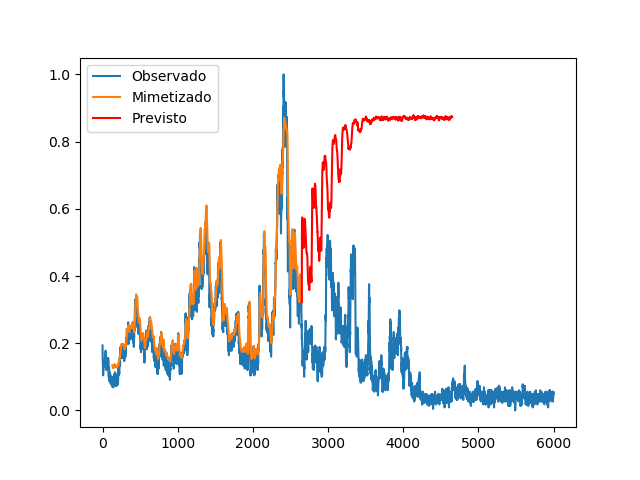

In [251]:
plt.figure()
plt.plot(norm,label="Observado")
plt.plot(x_pred,pred,label="Mimetizado")
plt.plot(tx_pred,t_pred,color="red",label="Previsto")
plt.legend()
plt.show()

## 2.3 Múltiplas Camadas - LSTM

Para utilizar múltiplas camadas, o argumento 'return_sequences=True' deve ser informado ao construtor da camada. Este argumento informa que na saída da camada, o estado atual da camada ($C_T$ e $h_T$) deverá ser anexado a saida. Portanto, na última camada especificamos 'return_sequences=False', que é o argumento padrão.

In [265]:
model = Sequential()

#tamanho da subserie temporal
tamanhoSerie = 128

#Apenas uma camada para inicio:
model.add(LSTM(units=int(1.5*tamanhoSerie),return_sequences=True,input_shape=(tamanhoSerie,1)))
model.add(LSTM(units=tamanhoSerie))
model.add(Dense(1, activation='sigmoid'))

In [266]:
model.compile(loss='mean_squared_error', optimizer=RMSprop())
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 128, 192)          148992    
_________________________________________________________________
lstm_10 (LSTM)               (None, 128)               164352    
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 129       
Total params: 313,473
Trainable params: 313,473
Non-trainable params: 0
_________________________________________________________________


In [267]:
def batchGen(serie,tamanhoSerie,tamnanhoLote):
     while True:
        x_shape = (tamnanhoLote, tamanhoSerie,1)
        x_batch = np.zeros(shape=x_shape)
        y_shape = (tamnanhoLote, 1)
        y_batch = np.zeros(shape=y_shape)
        
        random = np.random.randint(len(serie)-tamnanhoLote*tamanhoSerie-1)
        for b in range(tamnanhoLote):
            x_batch[b,:,0] = serie[random:random+tamanhoSerie][0].values
            y_batch[b,:] = serie.iloc[random+tamanhoSerie+1].values[0]
            random = random+tamanhoSerie
        yield(x_batch,y_batch)
gen = batchGen(norm,tamanhoSerie,10)
model.fit_generator(gen, epochs=10,steps_per_epoch=20)

Epoch 1/10
20/20 [==============================] - 41s 2s/step - loss: 0.0544
Epoch 2/10
20/20 [==============================] - 35s 2s/step - loss: 0.0271
Epoch 3/10
20/20 [==============================] - 34s 2s/step - loss: 0.0307
Epoch 4/10
20/20 [==============================] - 36s 2s/step - loss: 0.0344
Epoch 5/10
20/20 [==============================] - 50s 3s/step - loss: 0.0243
Epoch 6/10
20/20 [==============================] - 46s 2s/step - loss: 0.0287
Epoch 7/10
20/20 [==============================] - 37s 2s/step - loss: 0.0239
Epoch 8/10
20/20 [==============================] - 45s 2s/step - loss: 0.0247
Epoch 9/10
20/20 [==============================] - 46s 2s/step - loss: 0.0134
Epoch 10/10
20/20 [==============================] - 47s 2s/step - loss: 0.0084


<IPython.core.display.Javascript object>


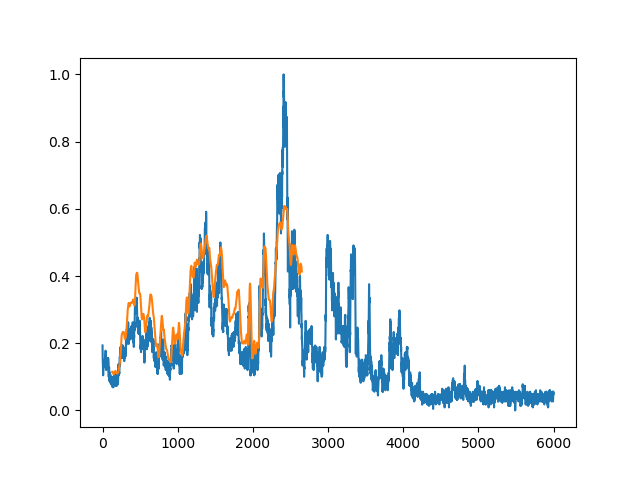

In [268]:
pedacos = norm[:len(norm)-len(norm)%tamanhoSerie][0].values
toPredict = []
for i in range(int(3*len(pedacos)/7)):
    toPredict.append(pedacos[i:i+tamanhoSerie])
toPredict = np.array(toPredict)
shape = toPredict.shape
toPredict = toPredict.reshape(shape[0],shape[1],1)
pred = model.predict(toPredict)
pred = pred.reshape(pred.shape[0]*pred.shape[1])
x_pred = [i for i in range(tamanhoSerie+1,len(pred)+tamanhoSerie+1)]

plt.figure()
plt.plot(norm)
plt.plot(x_pred, pred)
plt.show()

In [269]:
def stepPredict(model,toPredict,tamanhoSerie, serie, acc):
    serie2 = serie
    
    #prevendo o proximo passo de tempo 
    pred = model.predict(toPredict)
    pred = pred.reshape(pred.shape[0]*pred.shape[1])
    acc = np.append(acc,pred[len(pred)-1])
    serie2 = np.append(serie,pred[len(pred)-1]+np.random.rand()/10)
    
    #adicionando o proximo passo
    batch = np.zeros(shape=(tamanhoSerie,tamanhoSerie,1))
    
    for i in range(tamanhoSerie-1,0,-1):
        batch[i,:,0] = serie2[len(serie2)-1-i-tamanhoSerie:len(serie2)-1-i]
    
    return np.array(batch), serie2, acc

In [270]:
toPredict2 = toPredict
pred2 = pred

toPredict2, pred2, t_pred = stepPredict(model, toPredict2, tamanhoSerie,pred,[])
tx_pred = [x_pred[len(x_pred)-1]]
for i in range(2000):
    toPredict2, pred2, t_pred = stepPredict(model, toPredict2, tamanhoSerie,pred2,t_pred)
    tx_pred.append(tx_pred[len(tx_pred)-1]+1)
    print("Time step:", tx_pred[len(tx_pred)-1], i)
    #print(toPredict2)

Time step: 2652 0
Time step: 2653 1
Time step: 2654 2
Time step: 2655 3
Time step: 2656 4
Time step: 2657 5
Time step: 2658 6
Time step: 2659 7
Time step: 2660 8
Time step: 2661 9
Time step: 2662 10
Time step: 2663 11
Time step: 2664 12
Time step: 2665 13
Time step: 2666 14
Time step: 2667 15
Time step: 2668 16
Time step: 2669 17
Time step: 2670 18
Time step: 2671 19
Time step: 2672 20
Time step: 2673 21
Time step: 2674 22
Time step: 2675 23
Time step: 2676 24
Time step: 2677 25
Time step: 2678 26
Time step: 2679 27
Time step: 2680 28
Time step: 2681 29
Time step: 2682 30
Time step: 2683 31
Time step: 2684 32
Time step: 2685 33
Time step: 2686 34
Time step: 2687 35
Time step: 2688 36
Time step: 2689 37
Time step: 2690 38
Time step: 2691 39
Time step: 2692 40
Time step: 2693 41
Time step: 2694 42
Time step: 2695 43
Time step: 2696 44
Time step: 2697 45
Time step: 2698 46
Time step: 2699 47
Time step: 2700 48
Time step: 2701 49
Time step: 2702 50
Time step: 2703 51
Time step: 2704 52
Tim

Time step: 3068 416
Time step: 3069 417
Time step: 3070 418
Time step: 3071 419
Time step: 3072 420
Time step: 3073 421
Time step: 3074 422
Time step: 3075 423
Time step: 3076 424
Time step: 3077 425
Time step: 3078 426
Time step: 3079 427
Time step: 3080 428
Time step: 3081 429
Time step: 3082 430
Time step: 3083 431
Time step: 3084 432
Time step: 3085 433
Time step: 3086 434
Time step: 3087 435
Time step: 3088 436
Time step: 3089 437
Time step: 3090 438
Time step: 3091 439
Time step: 3092 440
Time step: 3093 441
Time step: 3094 442
Time step: 3095 443
Time step: 3096 444
Time step: 3097 445
Time step: 3098 446
Time step: 3099 447
Time step: 3100 448
Time step: 3101 449
Time step: 3102 450
Time step: 3103 451
Time step: 3104 452
Time step: 3105 453
Time step: 3106 454
Time step: 3107 455
Time step: 3108 456
Time step: 3109 457
Time step: 3110 458
Time step: 3111 459
Time step: 3112 460
Time step: 3113 461
Time step: 3114 462
Time step: 3115 463
Time step: 3116 464
Time step: 3117 465


Time step: 3478 826
Time step: 3479 827
Time step: 3480 828
Time step: 3481 829
Time step: 3482 830
Time step: 3483 831
Time step: 3484 832
Time step: 3485 833
Time step: 3486 834
Time step: 3487 835
Time step: 3488 836
Time step: 3489 837
Time step: 3490 838
Time step: 3491 839
Time step: 3492 840
Time step: 3493 841
Time step: 3494 842
Time step: 3495 843
Time step: 3496 844
Time step: 3497 845
Time step: 3498 846
Time step: 3499 847
Time step: 3500 848
Time step: 3501 849
Time step: 3502 850
Time step: 3503 851
Time step: 3504 852
Time step: 3505 853
Time step: 3506 854
Time step: 3507 855
Time step: 3508 856
Time step: 3509 857
Time step: 3510 858
Time step: 3511 859
Time step: 3512 860
Time step: 3513 861
Time step: 3514 862
Time step: 3515 863
Time step: 3516 864
Time step: 3517 865
Time step: 3518 866
Time step: 3519 867
Time step: 3520 868
Time step: 3521 869
Time step: 3522 870
Time step: 3523 871
Time step: 3524 872
Time step: 3525 873
Time step: 3526 874
Time step: 3527 875


Time step: 3877 1225
Time step: 3878 1226
Time step: 3879 1227
Time step: 3880 1228
Time step: 3881 1229
Time step: 3882 1230
Time step: 3883 1231
Time step: 3884 1232
Time step: 3885 1233
Time step: 3886 1234
Time step: 3887 1235
Time step: 3888 1236
Time step: 3889 1237
Time step: 3890 1238
Time step: 3891 1239
Time step: 3892 1240
Time step: 3893 1241
Time step: 3894 1242
Time step: 3895 1243
Time step: 3896 1244
Time step: 3897 1245
Time step: 3898 1246
Time step: 3899 1247
Time step: 3900 1248
Time step: 3901 1249
Time step: 3902 1250
Time step: 3903 1251
Time step: 3904 1252
Time step: 3905 1253
Time step: 3906 1254
Time step: 3907 1255
Time step: 3908 1256
Time step: 3909 1257
Time step: 3910 1258
Time step: 3911 1259
Time step: 3912 1260
Time step: 3913 1261
Time step: 3914 1262
Time step: 3915 1263
Time step: 3916 1264
Time step: 3917 1265
Time step: 3918 1266
Time step: 3919 1267
Time step: 3920 1268
Time step: 3921 1269
Time step: 3922 1270
Time step: 3923 1271
Time step: 39

Time step: 4268 1616
Time step: 4269 1617
Time step: 4270 1618
Time step: 4271 1619
Time step: 4272 1620
Time step: 4273 1621
Time step: 4274 1622
Time step: 4275 1623
Time step: 4276 1624
Time step: 4277 1625
Time step: 4278 1626
Time step: 4279 1627
Time step: 4280 1628
Time step: 4281 1629
Time step: 4282 1630
Time step: 4283 1631
Time step: 4284 1632
Time step: 4285 1633
Time step: 4286 1634
Time step: 4287 1635
Time step: 4288 1636
Time step: 4289 1637
Time step: 4290 1638
Time step: 4291 1639
Time step: 4292 1640
Time step: 4293 1641
Time step: 4294 1642
Time step: 4295 1643
Time step: 4296 1644
Time step: 4297 1645
Time step: 4298 1646
Time step: 4299 1647
Time step: 4300 1648
Time step: 4301 1649
Time step: 4302 1650
Time step: 4303 1651
Time step: 4304 1652
Time step: 4305 1653
Time step: 4306 1654
Time step: 4307 1655
Time step: 4308 1656
Time step: 4309 1657
Time step: 4310 1658
Time step: 4311 1659
Time step: 4312 1660
Time step: 4313 1661
Time step: 4314 1662
Time step: 43

<IPython.core.display.Javascript object>


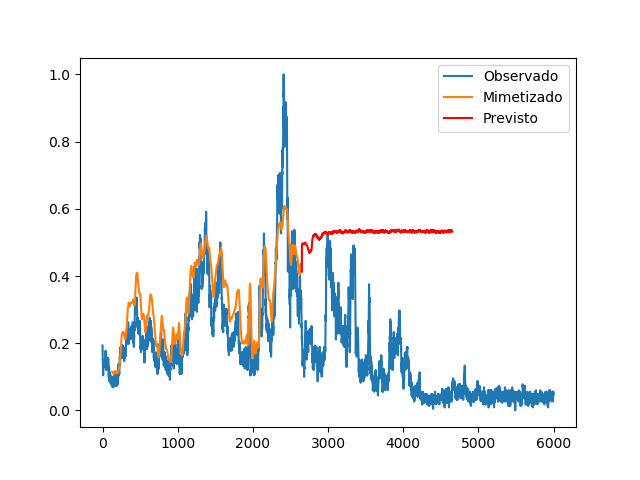

In [271]:
plt.figure()
plt.plot(norm,label="Observado")
plt.plot(x_pred,pred,label="Mimetizado")
plt.plot(tx_pred,t_pred,color="red",label="Previsto")
plt.legend()
plt.show()